# Multirotor co-design with FAST-OAD

FAST-OAD is a framework for performing rapid Overall Aircraft Design co-developped by ONERA and ISAE-SUPAERO. The computational core of FAST-OAD is based on the  [OpenMDAO framework](https://openmdao.org/).

## 1. Setting up and analyzing the initial problem

To organize our work, we propose to use two user folders `data/` and `workdir/`. For instance, in `data/` we store a XML file which describes the [CeRAS reference case](http://ceras.ilr.rwth-aachen.de/trac/wiki/CeRAS/AircraftDesigns/CSR01). In `workdir/`, we store files generated or modified by FAST-OAD.

In [1]:
import os
import os.path as pth
import openmdao.api as om
from fastoad import api
import logging
from fastoad.utils.postprocessing import VariableViewer
import shutil
from models.register import register_openmdao_systems
from models.trajectory import plot_trajectory
register_openmdao_systems()
DATA_FOLDER_PATH = 'data'

WORK_FOLDER_PATH = 'workdir'

CONFIGURATION_FILE = pth.join(DATA_FOLDER_PATH,'multirotor.toml')
REF_INPUT_FILE = pth.join(DATA_FOLDER_PATH,'problem_inputs_ref.xml')
# For having log messages on screen
logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')

# For using all screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


After defining a configuration file name, we can ask FAST-OAD to generate a default configuration file based on the default OAD model implemented in the framework:

In this configuration file, we have specified an input file name 'problem_inputs.xml'. We can ask FAST-OAD to generate the inputs of the default model with the CeRAS parameters as default values:

In [2]:
api.generate_inputs(CONFIGURATION_FILE, REF_INPUT_FILE, overwrite=True)

INFO    : Problem inputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_inputs.xml


You can now checkout the generated [input file](./workdir/problem_inputs.xml). As shown previously in the user file architecture, the values in this file can be modified by the user and will be considered by FAST-OAD when executing a computational process.

A useful feature that FAST-OAD provides is to list the outputs of the model defined in the configuration file:

In [3]:
api.list_variables(CONFIGURATION_FILE)

,I/O,Name,Description
0,IN,data:battery:capacity:discharge_limit,
1,IN,data:battery:cell:voltage,
2,IN,data:battery:energy:ref,
3,IN,data:battery:mass:k,
4,IN,data:battery:mass:ref,
5,IN,data:battery:voltage:k,
6,IN,data:esc:efficiency,
7,IN,data:esc:mass:ref,
8,IN,data:esc:power:ref,
9,IN,data:frame:arm:density,


Another useful feature is to list the modules of the model defined in the configuration file:

In [4]:
api.list_systems(CONFIGURATION_FILE)

== AVAILABLE SYSTEM IDENTIFIERS ====================================================================
----------------------------------------------------------------------------------------------------
  IDENTIFIER:   fastoad.aerodynamics.highspeed.legacy
  PATH:         d:\users\s.delbecq\appdata\local\programs\miniconda3\lib\site-packages\fastoad\models\aerodynamics\aerodynamics_high_speed.py
  DOMAIN:       Aerodynamics
  DESCRIPTION:  
    Computes aerodynamic polar of the aircraft in cruise conditions.

    Drag contributions of each part of the aircraft are computed though analytical
    models.

----------------------------------------------------------------------------------------------------
  IDENTIFIER:   fastoad.aerodynamics.landing.legacy
  PATH:         d:\users\s.delbecq\appdata\local\programs\miniconda3\lib\site-packages\fastoad\models\aerodynamics\aerodynamics_landing.py
  DOMAIN:       Aerodynamics
  DESCRIPTION:  
    Computes aerodynamic characteristics at landing.

Another useful feature is the [N2 diagram](http://openmdao.org/twodocs/versions/latest/basic_guide/make_n2.html) visualization available in OpenMDAO to see the structure of the model:

In [5]:
N2_FILE = pth.join(WORK_FOLDER_PATH, 'n2.html')
api.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width='100%', height='500px')

INFO    : N2 diagram written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\n2.html


Alternatively, you can create a [WhatsOpt](https://github.com/OneraHub/WhatsOpt-Doc#whatsopt-documentation) account to generate the XDSM of the problem. If your account is created, you may uncomment next lines and run them (this should take ~ 1 min):

In [6]:
# XDSM_FILE = pth.join(WORK_FOLDER_PATH, 'xdsm.html')
# api.write_xdsm(CONFIGURATION_FILE, XDSM_FILE, overwrite=True)
# from IPython.display import IFrame
# IFrame(src=XDSM_FILE, width='100%', height='500px')

## 2. Running your first MDA

### CeRAS
Here we run an MDA, that is solving the multidisciplinary couplings using the different nested solvers in the model, without running the optimization problem even if it is defined in the configuration file.

In [7]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_inputs.xml')
api.variable_viewer(INPUT_FILE)

In [8]:
eval_problem = api.evaluate_problem(CONFIGURATION_FILE, overwrite=True)

INFO    : Computation finished after 0.06 seconds
INFO    : Problem outputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_outputs.xml


Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01831160000000054 seconds.


Let's save these results. We will use them in the next workbook, that shows some post-processing utilities.

In [9]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_outputs.xml')

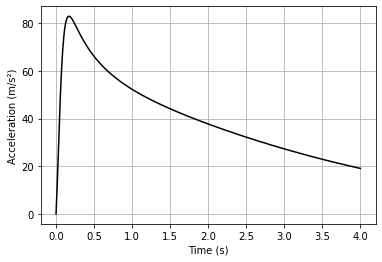

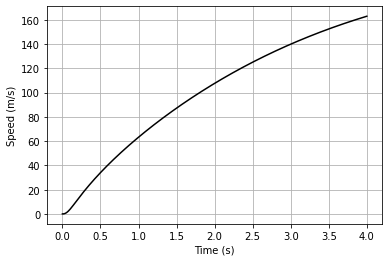

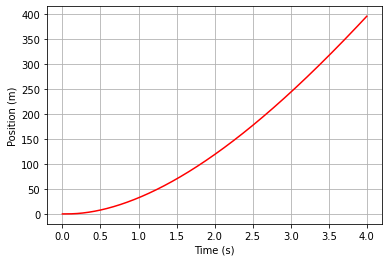

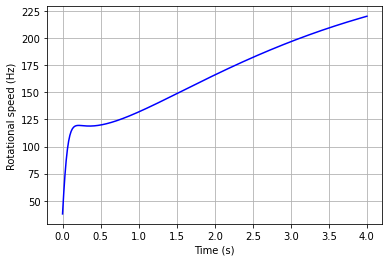

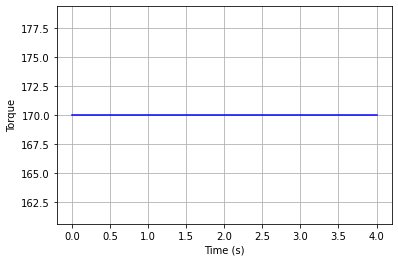

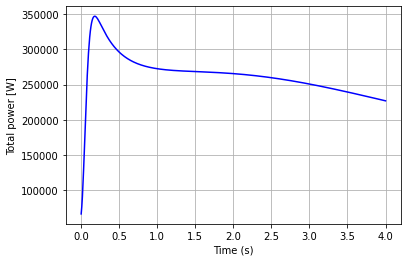

In [10]:
plot_trajectory(eval_problem.model.trajectory.trajectory.res)

The `variable-viewer` provides a way to inspect the content of the XML file. The dropdown lists above the table allow to filter the displayed variable.

In [11]:
api.variable_viewer(OUTPUT_FILE)

## 3. Running your first MDO

## CeRAS 2750 nm optimization

As seen earlier, the current aircraft configuration is estimated as unstable. We will fix this using a simple optimization problem that will move wing position so the static margin is at least +5%, while keeping the fuel consumption as low as possible. 

The default configuration file defines this optimization problem that aims at:
- minimizing the fuel consumption for the mission (objective),
- with respect to the wing position (design variables),
- subject to a static margin (constraints).

*(This run should take a few dozen seconds)*

To visualize and edit the optimization problem definition (present in the configuration file .toml) you can use the `optimization_viewer` tool. If design variables or constraints have active bounds they are yellow whereas they are red if they are violated. Modifiying the `Initial Value` will modify the input file defined in the configuration file .toml whereas `Value` corresponds to the value found in the output file defined in the configuration file (here it is the 800 nm MDA run).

In [7]:
api.optimization_viewer(CONFIGURATION_FILE)

In [3]:
optim_problem = api.optimize_problem(CONFIGURATION_FILE, overwrite=True)

Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.028924599999999856 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.020387899999999348 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.02312370000000108 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.021379300000001322 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.02671430000000008 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.0259911000000006 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.02121249999999897 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.019235500000000627 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.0208692

Simulation interval    : 0.0 - 4.365114387950709 seconds.
Elapsed simulation time: 0.018777099999999436 seconds.
Simulation interval    : 0.0 - 4.365114387950709 seconds.
Elapsed simulation time: 0.018624199999999647 seconds.
Simulation interval    : 0.0 - 4.365114387950709 seconds.
Elapsed simulation time: 0.01932299999999998 seconds.
Simulation interval    : 0.0 - 4.365114387950709 seconds.
Elapsed simulation time: 0.024497200000000774 seconds.
Simulation interval    : 0.0 - 4.365114387950709 seconds.
Elapsed simulation time: 0.01830690000000068 seconds.
Simulation interval    : 0.0 - 4.365114387950709 seconds.
Elapsed simulation time: 0.01973409999999909 seconds.
Simulation interval    : 0.0 - 4.365114387950709 seconds.
Elapsed simulation time: 0.018076900000000506 seconds.
Simulation interval    : 0.0 - 4.365114387950709 seconds.
Elapsed simulation time: 0.01930199999999971 seconds.
Simulation interval    : 0.0 - 2.0000000001363474 seconds.
Elapsed simulation time: 0.02077360000000

Simulation interval    : 0.0 - 2.0008241005382614 seconds.
Elapsed simulation time: 0.018330500000001138 seconds.
Simulation interval    : 0.0 - 2.0008241005382614 seconds.
Elapsed simulation time: 0.018299100000000124 seconds.
Simulation interval    : 0.0 - 2.0008241005382614 seconds.
Elapsed simulation time: 0.018446300000000804 seconds.
Simulation interval    : 0.0 - 2.0008241005382614 seconds.
Elapsed simulation time: 0.018704299999999563 seconds.
Simulation interval    : 0.0 - 2.0008241005382614 seconds.
Elapsed simulation time: 0.01881429999999895 seconds.
Simulation interval    : 0.0 - 2.0008241005382614 seconds.
Elapsed simulation time: 0.018027699999997537 seconds.
Simulation interval    : 0.0 - 2.0008241005382614 seconds.
Elapsed simulation time: 0.018050599999998695 seconds.
Simulation interval    : 0.0 - 2.0008241005382614 seconds.
Elapsed simulation time: 0.01853099999999941 seconds.
Simulation interval    : 0.0 - 2.0008241005382614 seconds.
Elapsed simulation time: 0.0185

Simulation interval    : 0.0 - 1.9999999999999998 seconds.
Elapsed simulation time: 0.024961600000001027 seconds.
Simulation interval    : 0.0 - 1.9999999999999998 seconds.
Elapsed simulation time: 0.051185499999998996 seconds.
Simulation interval    : 0.0 - 1.9999999999999998 seconds.
Elapsed simulation time: 0.01981879999999947 seconds.
Simulation interval    : 0.0 - 1.9999999999999998 seconds.
Elapsed simulation time: 0.020237800000000306 seconds.
Simulation interval    : 0.0 - 1.9999999999999998 seconds.
Elapsed simulation time: 0.02392279999999758 seconds.
Simulation interval    : 0.0 - 1.9999999999999998 seconds.
Elapsed simulation time: 0.022121399999999625 seconds.
Simulation interval    : 0.0 - 1.9999999999999998 seconds.
Elapsed simulation time: 0.02035359999999997 seconds.
Simulation interval    : 0.0 - 1.9999999999999998 seconds.
Elapsed simulation time: 0.029712299999999914 seconds.
Simulation interval    : 0.0 - 1.9999999999999998 seconds.
Elapsed simulation time: 0.02152

Simulation interval    : 0.0 - 2.366430655462819 seconds.
Elapsed simulation time: 0.01885989999999893 seconds.
Simulation interval    : 0.0 - 2.366430655462819 seconds.
Elapsed simulation time: 0.01950779999999952 seconds.
Simulation interval    : 0.0 - 2.366431655462819 seconds.
Elapsed simulation time: 0.01821040000000096 seconds.
Simulation interval    : 0.0 - 2.366430655462819 seconds.
Elapsed simulation time: 0.02223160000000135 seconds.
Simulation interval    : 0.0 - 2.366430655462819 seconds.
Elapsed simulation time: 0.03530349999999771 seconds.
Simulation interval    : 0.0 - 2.366430655462819 seconds.
Elapsed simulation time: 0.026943299999999226 seconds.
Simulation interval    : 0.0 - 2.366430655462819 seconds.
Elapsed simulation time: 0.02933840000000032 seconds.
Simulation interval    : 0.0 - 2.366430655462819 seconds.
Elapsed simulation time: 0.029590200000001232 seconds.
Simulation interval    : 0.0 - 2.366430655462819 seconds.
Elapsed simulation time: 0.01887839999999840

Simulation interval    : 0.0 - 2.574803189372038 seconds.
Elapsed simulation time: 0.017839799999997297 seconds.
Simulation interval    : 0.0 - 2.538728463108554 seconds.
Elapsed simulation time: 0.017627099999998563 seconds.
Simulation interval    : 0.0 - 2.538728463108554 seconds.
Elapsed simulation time: 0.023621800000000803 seconds.
Simulation interval    : 0.0 - 2.538728463108554 seconds.
Elapsed simulation time: 0.01884650000000221 seconds.
Simulation interval    : 0.0 - 2.538728463108554 seconds.
Elapsed simulation time: 0.01808420000000055 seconds.
Simulation interval    : 0.0 - 2.538728463108554 seconds.
Elapsed simulation time: 0.018183400000001626 seconds.
Simulation interval    : 0.0 - 2.538728463108554 seconds.
Elapsed simulation time: 0.017911199999996796 seconds.
Simulation interval    : 0.0 - 2.538728463108554 seconds.
Elapsed simulation time: 0.018227499999998287 seconds.
Simulation interval    : 0.0 - 2.538728463108554 seconds.
Elapsed simulation time: 0.0183107999999

Simulation interval    : 0.0 - 2.478052668307043 seconds.
Elapsed simulation time: 0.01790680000000222 seconds.
Simulation interval    : 0.0 - 2.478052668307043 seconds.
Elapsed simulation time: 0.018313799999997826 seconds.
Simulation interval    : 0.0 - 2.478052668307043 seconds.
Elapsed simulation time: 0.01823060000000254 seconds.
Simulation interval    : 0.0 - 2.478052668307043 seconds.
Elapsed simulation time: 0.017634899999997344 seconds.
Simulation interval    : 0.0 - 2.478052668307043 seconds.
Elapsed simulation time: 0.018278099999999853 seconds.
Simulation interval    : 0.0 - 2.478052668307043 seconds.
Elapsed simulation time: 0.017587999999999937 seconds.
Simulation interval    : 0.0 - 2.478052668307043 seconds.
Elapsed simulation time: 0.018103400000001102 seconds.
Simulation interval    : 0.0 - 2.7477035049775096 seconds.
Elapsed simulation time: 0.020471799999999263 seconds.
Simulation interval    : 0.0 - 2.5706695027151323 seconds.
Elapsed simulation time: 0.01799439999

Simulation interval    : 0.0 - 2.5626107367928044 seconds.
Elapsed simulation time: 0.01831539999999876 seconds.
Simulation interval    : 0.0 - 2.5626107367928044 seconds.
Elapsed simulation time: 0.01810430000000096 seconds.
Simulation interval    : 0.0 - 2.562611736792805 seconds.
Elapsed simulation time: 0.018093300000000312 seconds.
Simulation interval    : 0.0 - 2.5626107367928044 seconds.
Elapsed simulation time: 0.018873800000001495 seconds.
Simulation interval    : 0.0 - 2.5626107367928044 seconds.
Elapsed simulation time: 0.018379300000002985 seconds.
Simulation interval    : 0.0 - 2.5626107367928044 seconds.
Elapsed simulation time: 0.017881599999999054 seconds.
Simulation interval    : 0.0 - 2.5626107367928044 seconds.
Elapsed simulation time: 0.0181666000000007 seconds.
Simulation interval    : 0.0 - 2.5626107367928044 seconds.
Elapsed simulation time: 0.018006100000000913 seconds.
Simulation interval    : 0.0 - 2.5626107367928044 seconds.
Elapsed simulation time: 0.0182321

Simulation interval    : 0.0 - 2.5432404159367192 seconds.
Elapsed simulation time: 0.018072199999998872 seconds.
Simulation interval    : 0.0 - 2.376674508080058 seconds.
Elapsed simulation time: 0.020522499999998445 seconds.
Simulation interval    : 0.0 - 2.505280328151614 seconds.
Elapsed simulation time: 0.018179100000001114 seconds.
Simulation interval    : 0.0 - 2.523030468026532 seconds.
Elapsed simulation time: 0.01819929999999914 seconds.
Simulation interval    : 0.0 - 2.523030468026532 seconds.
Elapsed simulation time: 0.017884300000002185 seconds.
Simulation interval    : 0.0 - 2.523030468026532 seconds.
Elapsed simulation time: 0.018423299999998477 seconds.
Simulation interval    : 0.0 - 2.523030468026532 seconds.
Elapsed simulation time: 0.01802550000000025 seconds.
Simulation interval    : 0.0 - 2.523030468026532 seconds.
Elapsed simulation time: 0.01772539999999978 seconds.
Simulation interval    : 0.0 - 2.523030468026532 seconds.
Elapsed simulation time: 0.0178346999999

Simulation interval    : 0.0 - 2.5221007289538 seconds.
Elapsed simulation time: 0.01845209999999753 seconds.
Simulation interval    : 0.0 - 2.5221007289538 seconds.
Elapsed simulation time: 0.017941199999999213 seconds.
Simulation interval    : 0.0 - 2.5221007289538 seconds.
Elapsed simulation time: 0.017817999999998335 seconds.
Simulation interval    : 0.0 - 2.5221007289538 seconds.
Elapsed simulation time: 0.01826340000000215 seconds.
Simulation interval    : 0.0 - 2.5221007289538 seconds.
Elapsed simulation time: 0.018374800000000135 seconds.
Simulation interval    : 0.0 - 2.5221007289538 seconds.
Elapsed simulation time: 0.017977600000001814 seconds.
Simulation interval    : 0.0 - 2.5221007289538 seconds.
Elapsed simulation time: 0.01790760000000091 seconds.
Simulation interval    : 0.0 - 2.5221007289538 seconds.
Elapsed simulation time: 0.01790499999999895 seconds.
Simulation interval    : 0.0 - 2.5221007289538 seconds.
Elapsed simulation time: 0.01785809999999799 seconds.
Simula

Simulation interval    : 0.0 - 2.730240735293462 seconds.
Elapsed simulation time: 0.0177049000000018 seconds.
Simulation interval    : 0.0 - 2.730240735293462 seconds.
Elapsed simulation time: 0.018145700000001597 seconds.
Simulation interval    : 0.0 - 2.730240735293462 seconds.
Elapsed simulation time: 0.0178477000000008 seconds.
Simulation interval    : 0.0 - 2.730240735293462 seconds.
Elapsed simulation time: 0.01777230000000074 seconds.
Simulation interval    : 0.0 - 2.7302417352934625 seconds.
Elapsed simulation time: 0.017932399999999404 seconds.
Simulation interval    : 0.0 - 2.730240735293462 seconds.
Elapsed simulation time: 0.018090099999998444 seconds.
Simulation interval    : 0.0 - 2.730240735293462 seconds.
Elapsed simulation time: 0.018108399999999136 seconds.
Simulation interval    : 0.0 - 2.730240735293462 seconds.
Elapsed simulation time: 0.01792650000000151 seconds.
Simulation interval    : 0.0 - 2.730240735293462 seconds.
Elapsed simulation time: 0.0181785000000012

Simulation interval    : 0.0 - 2.8840327301323936 seconds.
Elapsed simulation time: 0.018160999999999206 seconds.
Simulation interval    : 0.0 - 2.8840327301323936 seconds.
Elapsed simulation time: 0.01816649999999953 seconds.
Simulation interval    : 0.0 - 3.672731828407369 seconds.
Elapsed simulation time: 0.017839899999998465 seconds.
Simulation interval    : 0.0 - 2.9629026399598914 seconds.
Elapsed simulation time: 0.018194299999997554 seconds.
Simulation interval    : 0.0 - 2.904910315900653 seconds.
Elapsed simulation time: 0.017727299999997115 seconds.
Simulation interval    : 0.0 - 2.904910315900653 seconds.
Elapsed simulation time: 0.017969799999995928 seconds.
Simulation interval    : 0.0 - 2.904910315900653 seconds.
Elapsed simulation time: 0.018036899999998468 seconds.
Simulation interval    : 0.0 - 2.904910315900653 seconds.
Elapsed simulation time: 0.01806320000000028 seconds.
Simulation interval    : 0.0 - 2.904910315900653 seconds.
Elapsed simulation time: 0.0184167000

Simulation interval    : 0.0 - 2.917273454587559 seconds.
Elapsed simulation time: 0.01798329999999737 seconds.
Simulation interval    : 0.0 - 2.917273454587559 seconds.
Elapsed simulation time: 0.018089199999998584 seconds.
Simulation interval    : 0.0 - 2.917273454587559 seconds.
Elapsed simulation time: 0.018182200000005366 seconds.
Simulation interval    : 0.0 - 2.917273454587559 seconds.
Elapsed simulation time: 0.018166800000003036 seconds.
Simulation interval    : 0.0 - 2.917273454587559 seconds.
Elapsed simulation time: 0.01784529999999762 seconds.
Simulation interval    : 0.0 - 2.917273454587559 seconds.
Elapsed simulation time: 0.01819760000000059 seconds.
Simulation interval    : 0.0 - 2.917273454587559 seconds.
Elapsed simulation time: 0.017811399999999367 seconds.
Simulation interval    : 0.0 - 2.917273454587559 seconds.
Elapsed simulation time: 0.01809759999999727 seconds.
Simulation interval    : 0.0 - 2.917273454587559 seconds.
Elapsed simulation time: 0.018046699999999

Simulation interval    : 0.0 - 3.004045565504498 seconds.
Elapsed simulation time: 0.01785979999999654 seconds.
Simulation interval    : 0.0 - 3.004045565504498 seconds.
Elapsed simulation time: 0.01781700000000086 seconds.
Simulation interval    : 0.0 - 3.004045565504498 seconds.
Elapsed simulation time: 0.017731799999999964 seconds.
Simulation interval    : 0.0 - 3.004045565504498 seconds.
Elapsed simulation time: 0.01847079999999579 seconds.
Simulation interval    : 0.0 - 3.004045565504498 seconds.
Elapsed simulation time: 0.01795999999999509 seconds.
Simulation interval    : 0.0 - 3.004045565504498 seconds.
Elapsed simulation time: 0.017736599999999214 seconds.
Simulation interval    : 0.0 - 3.004045565504498 seconds.
Elapsed simulation time: 0.017860100000000045 seconds.
Simulation interval    : 0.0 - 3.004045565504498 seconds.
Elapsed simulation time: 0.017777499999994006 seconds.
Simulation interval    : 0.0 - 3.004045565504498 seconds.
Elapsed simulation time: 0.017966199999996

Simulation interval    : 0.0 - 3.04249390331729 seconds.
Elapsed simulation time: 0.018101300000004983 seconds.
Simulation interval    : 0.0 - 3.04249390331729 seconds.
Elapsed simulation time: 0.017931299999993655 seconds.
Simulation interval    : 0.0 - 3.04249390331729 seconds.
Elapsed simulation time: 0.018209400000003484 seconds.
Simulation interval    : 0.0 - 3.04249390331729 seconds.
Elapsed simulation time: 0.020076599999995892 seconds.
Simulation interval    : 0.0 - 3.04249390331729 seconds.
Elapsed simulation time: 0.0182651000000007 seconds.
Simulation interval    : 0.0 - 3.04249390331729 seconds.
Elapsed simulation time: 0.018027400000001137 seconds.
Simulation interval    : 0.0 - 3.04249390331729 seconds.
Elapsed simulation time: 0.018091400000002977 seconds.
Simulation interval    : 0.0 - 3.04249390331729 seconds.
Elapsed simulation time: 0.01806460000000243 seconds.
Simulation interval    : 0.0 - 3.457948374231352 seconds.
Elapsed simulation time: 0.017847699999997246 sec

Simulation interval    : 0.0 - 3.0444388998580982 seconds.
Elapsed simulation time: 0.018047199999998043 seconds.
Simulation interval    : 0.0 - 3.0444388998580982 seconds.
Elapsed simulation time: 0.0183065999999954 seconds.
Simulation interval    : 0.0 - 3.0444388998580982 seconds.
Elapsed simulation time: 0.0176368999999994 seconds.
Simulation interval    : 0.0 - 3.0444398998580984 seconds.
Elapsed simulation time: 0.01802709999999763 seconds.
Simulation interval    : 0.0 - 3.0444388998580982 seconds.
Elapsed simulation time: 0.01788760000000167 seconds.
Simulation interval    : 0.0 - 3.0444388998580982 seconds.
Elapsed simulation time: 0.018225799999996184 seconds.
Simulation interval    : 0.0 - 3.0444388998580982 seconds.
Elapsed simulation time: 0.018307900000003485 seconds.
Simulation interval    : 0.0 - 3.0444388998580982 seconds.
Elapsed simulation time: 0.017767199999994432 seconds.
Simulation interval    : 0.0 - 3.0444388998580982 seconds.
Elapsed simulation time: 0.01798570

Simulation interval    : 0.0 - 3.044924630022846 seconds.
Elapsed simulation time: 0.018696899999994798 seconds.
Simulation interval    : 0.0 - 3.044924630022846 seconds.
Elapsed simulation time: 0.0183762999999999 seconds.
Simulation interval    : 0.0 - 3.044924630022846 seconds.
Elapsed simulation time: 0.018045799999995893 seconds.
Simulation interval    : 0.0 - 3.226265731927734 seconds.
Elapsed simulation time: 0.018049599999997668 seconds.
Simulation interval    : 0.0 - 3.0630587402133345 seconds.
Elapsed simulation time: 0.018322999999995204 seconds.
Simulation interval    : 0.0 - 3.0467380410418947 seconds.
Elapsed simulation time: 0.017984900000001858 seconds.
Simulation interval    : 0.0 - 3.0451059711247512 seconds.
Elapsed simulation time: 0.017872699999998076 seconds.
Simulation interval    : 0.0 - 3.0449534367392808 seconds.
Elapsed simulation time: 0.01801339999999385 seconds.
Simulation interval    : 0.0 - 3.0449534367392808 seconds.
Elapsed simulation time: 0.018187599

Simulation interval    : 0.0 - 3.044998026626116 seconds.
Elapsed simulation time: 0.017982499999995127 seconds.
Simulation interval    : 0.0 - 3.044998026626116 seconds.
Elapsed simulation time: 0.018105800000000727 seconds.
Simulation interval    : 0.0 - 3.044998026626116 seconds.
Elapsed simulation time: 0.01799540000000377 seconds.
Simulation interval    : 0.0 - 3.044998026626116 seconds.
Elapsed simulation time: 0.01831690000000208 seconds.
Simulation interval    : 0.0 - 3.044999026626116 seconds.
Elapsed simulation time: 0.018562100000004023 seconds.
Simulation interval    : 0.0 - 3.044998026626116 seconds.
Elapsed simulation time: 0.021896200000000476 seconds.
Simulation interval    : 0.0 - 3.044998026626116 seconds.
Elapsed simulation time: 0.018098600000001852 seconds.
Simulation interval    : 0.0 - 3.044998026626116 seconds.
Elapsed simulation time: 0.018054100000000517 seconds.
Simulation interval    : 0.0 - 3.044998026626116 seconds.
Elapsed simulation time: 0.0182451000000

Simulation interval    : 0.0 - 3.6754918719198213 seconds.
Elapsed simulation time: 0.017896100000001525 seconds.
Simulation interval    : 0.0 - 3.2483361515799207 seconds.
Elapsed simulation time: 0.01805729999999528 seconds.
Simulation interval    : 0.0 - 3.2483361515799207 seconds.
Elapsed simulation time: 0.01755059999999986 seconds.
Simulation interval    : 0.0 - 3.2483361515799207 seconds.
Elapsed simulation time: 0.018000000000000682 seconds.
Simulation interval    : 0.0 - 3.2483361515799207 seconds.
Elapsed simulation time: 0.018207800000006102 seconds.
Simulation interval    : 0.0 - 3.2483361515799207 seconds.
Elapsed simulation time: 0.017937700000004497 seconds.
Simulation interval    : 0.0 - 3.2483361515799207 seconds.
Elapsed simulation time: 0.017528899999994962 seconds.
Simulation interval    : 0.0 - 3.2483361515799207 seconds.
Elapsed simulation time: 0.017923700000004317 seconds.
Simulation interval    : 0.0 - 3.2483361515799207 seconds.
Elapsed simulation time: 0.0180

Simulation interval    : 0.0 - 3.3179579447893675 seconds.
Elapsed simulation time: 0.017714499999996747 seconds.
Simulation interval    : 0.0 - 3.3179579447893675 seconds.
Elapsed simulation time: 0.018018500000003712 seconds.
Simulation interval    : 0.0 - 3.3179579447893675 seconds.
Elapsed simulation time: 0.017916300000003105 seconds.
Simulation interval    : 0.0 - 3.3179579447893675 seconds.
Elapsed simulation time: 0.0181697000000014 seconds.
Simulation interval    : 0.0 - 3.3179579447893675 seconds.
Elapsed simulation time: 0.01822939999999562 seconds.
Simulation interval    : 0.0 - 3.3179579447893675 seconds.
Elapsed simulation time: 0.018062300000003972 seconds.
Simulation interval    : 0.0 - 3.3179579447893675 seconds.
Elapsed simulation time: 0.01783139999999861 seconds.
Simulation interval    : 0.0 - 3.3179579447893675 seconds.
Elapsed simulation time: 0.01843880000000553 seconds.
Simulation interval    : 0.0 - 3.3179579447893675 seconds.
Elapsed simulation time: 0.0181736

Simulation interval    : 0.0 - 3.3263605387913535 seconds.
Elapsed simulation time: 0.01775949999999682 seconds.
Simulation interval    : 0.0 - 3.3263605387913535 seconds.
Elapsed simulation time: 0.018231600000000014 seconds.
Simulation interval    : 0.0 - 3.3263605387913535 seconds.
Elapsed simulation time: 0.01899909999999494 seconds.
Simulation interval    : 0.0 - 3.326361538791354 seconds.
Elapsed simulation time: 0.01744289999999893 seconds.
Simulation interval    : 0.0 - 3.3263605387913535 seconds.
Elapsed simulation time: 0.01788570000000078 seconds.
Simulation interval    : 0.0 - 3.3263605387913535 seconds.
Elapsed simulation time: 0.01772900000000277 seconds.
Simulation interval    : 0.0 - 3.3263605387913535 seconds.
Elapsed simulation time: 0.017928400000002398 seconds.
Simulation interval    : 0.0 - 3.3263605387913535 seconds.
Elapsed simulation time: 0.017878099999997232 seconds.
Simulation interval    : 0.0 - 3.3263605387913535 seconds.
Elapsed simulation time: 0.01835879

Simulation interval    : 0.0 - 3.326508510843342 seconds.
Elapsed simulation time: 0.017843100000000334 seconds.
Simulation interval    : 0.0 - 3.326508510843342 seconds.
Elapsed simulation time: 0.018119299999995064 seconds.
Simulation interval    : 0.0 - 3.326508510843342 seconds.
Elapsed simulation time: 0.017891699999999844 seconds.
Simulation interval    : 0.0 - 3.326508510843342 seconds.
Elapsed simulation time: 0.018356000000004258 seconds.
Simulation interval    : 0.0 - 3.326508510843342 seconds.
Elapsed simulation time: 0.017459399999999903 seconds.
Simulation interval    : 0.0 - 3.326508510843342 seconds.
Elapsed simulation time: 0.017698699999996848 seconds.
Simulation interval    : 0.0 - 3.3102719529106888 seconds.
Elapsed simulation time: 0.018448799999994492 seconds.
Simulation interval    : 0.0 - 3.3218680678938917 seconds.
Elapsed simulation time: 0.01811659999999904 seconds.
Simulation interval    : 0.0 - 3.3249841365431774 seconds.
Elapsed simulation time: 0.018300899

Simulation interval    : 0.0 - 3.2800966525556987 seconds.
Elapsed simulation time: 0.018165699999997287 seconds.
Simulation interval    : 0.0 - 3.2800966525556987 seconds.
Elapsed simulation time: 0.02062800000000209 seconds.
Simulation interval    : 0.0 - 3.2800976525556984 seconds.
Elapsed simulation time: 0.01982269999999886 seconds.
Simulation interval    : 0.0 - 3.2800966525556987 seconds.
Elapsed simulation time: 0.02659359999999822 seconds.
Simulation interval    : 0.0 - 3.2800966525556987 seconds.
Elapsed simulation time: 0.018947199999999498 seconds.
Simulation interval    : 0.0 - 3.2800966525556987 seconds.
Elapsed simulation time: 0.019298599999999055 seconds.
Simulation interval    : 0.0 - 3.2800966525556987 seconds.
Elapsed simulation time: 0.018807500000001198 seconds.
Simulation interval    : 0.0 - 3.2800966525556987 seconds.
Elapsed simulation time: 0.018333999999995854 seconds.
Simulation interval    : 0.0 - 3.2800966525556987 seconds.
Elapsed simulation time: 0.01852

Simulation interval    : 0.0 - 3.5685464737584724 seconds.
Elapsed simulation time: 0.018444299999998748 seconds.
Simulation interval    : 0.0 - 3.917566295279598 seconds.
Elapsed simulation time: 0.020966299999997773 seconds.
Simulation interval    : 0.0 - 3.6202203071460786 seconds.
Elapsed simulation time: 0.01815249999999935 seconds.
Simulation interval    : 0.0 - 3.6202203071460786 seconds.
Elapsed simulation time: 0.01772009999999824 seconds.
Simulation interval    : 0.0 - 3.6202203071460786 seconds.
Elapsed simulation time: 0.017880300000001625 seconds.
Simulation interval    : 0.0 - 3.6202203071460786 seconds.
Elapsed simulation time: 0.01795810000000131 seconds.
Simulation interval    : 0.0 - 3.6202203071460786 seconds.
Elapsed simulation time: 0.017784599999998818 seconds.
Simulation interval    : 0.0 - 3.6202203071460786 seconds.
Elapsed simulation time: 0.017894499999997038 seconds.
Simulation interval    : 0.0 - 3.6202203071460786 seconds.
Elapsed simulation time: 0.018253

Simulation interval    : 0.0 - 3.6604096125279786 seconds.
Elapsed simulation time: 0.01787000000000205 seconds.
Simulation interval    : 0.0 - 3.6604096125279786 seconds.
Elapsed simulation time: 0.0182777999999999 seconds.
Simulation interval    : 0.0 - 3.6604096125279786 seconds.
Elapsed simulation time: 0.018460000000004584 seconds.
Simulation interval    : 0.0 - 3.6604096125279786 seconds.
Elapsed simulation time: 0.017770500000004574 seconds.
Simulation interval    : 0.0 - 3.6604096125279786 seconds.
Elapsed simulation time: 0.017887999999999238 seconds.
Simulation interval    : 0.0 - 3.6604096125279786 seconds.
Elapsed simulation time: 0.018210500000002128 seconds.
Simulation interval    : 0.0 - 3.6604096125279786 seconds.
Elapsed simulation time: 0.01821520000000021 seconds.
Simulation interval    : 0.0 - 3.6604096125279786 seconds.
Elapsed simulation time: 0.01816580000000556 seconds.
Simulation interval    : 0.0 - 3.6604096125279786 seconds.
Elapsed simulation time: 0.0178822

Simulation interval    : 0.0 - 3.7010466559437805 seconds.
Elapsed simulation time: 0.017976300000000833 seconds.
Simulation interval    : 0.0 - 3.7010456559437808 seconds.
Elapsed simulation time: 0.018053900000005285 seconds.
Simulation interval    : 0.0 - 3.7010456559437808 seconds.
Elapsed simulation time: 0.017781599999999287 seconds.
Simulation interval    : 0.0 - 3.7010456559437808 seconds.
Elapsed simulation time: 0.017949899999997854 seconds.
Simulation interval    : 0.0 - 3.7010456559437808 seconds.
Elapsed simulation time: 0.01880949999999615 seconds.
Simulation interval    : 0.0 - 3.7010456559437808 seconds.
Elapsed simulation time: 0.01798769999999905 seconds.
Simulation interval    : 0.0 - 3.7010456559437808 seconds.
Elapsed simulation time: 0.017933700000000385 seconds.
Simulation interval    : 0.0 - 3.7010456559437808 seconds.
Elapsed simulation time: 0.01799429999999802 seconds.
Simulation interval    : 0.0 - 3.7010456559437808 seconds.
Elapsed simulation time: 0.01809

Simulation interval    : 0.0 - 3.698530645768124 seconds.
Elapsed simulation time: 0.018721300000002827 seconds.
Simulation interval    : 0.0 - 3.698530645768124 seconds.
Elapsed simulation time: 0.017907899999997312 seconds.
Simulation interval    : 0.0 - 3.698530645768124 seconds.
Elapsed simulation time: 0.018329300000004878 seconds.
Simulation interval    : 0.0 - 3.698530645768124 seconds.
Elapsed simulation time: 0.01804729999999921 seconds.
Simulation interval    : 0.0 - 3.698530645768124 seconds.
Elapsed simulation time: 0.017907000000001005 seconds.
Simulation interval    : 0.0 - 3.698530645768124 seconds.
Elapsed simulation time: 0.018054799999994486 seconds.
Simulation interval    : 0.0 - 3.698530645768124 seconds.
Elapsed simulation time: 0.017782399999994425 seconds.
Simulation interval    : 0.0 - 3.698530645768124 seconds.
Elapsed simulation time: 0.018109899999998902 seconds.
Simulation interval    : 0.0 - 3.6985316457681248 seconds.
Elapsed simulation time: 0.01811430000

Simulation interval    : 0.0 - 3.6611835532235495 seconds.
Elapsed simulation time: 0.018445900000003235 seconds.
Simulation interval    : 0.0 - 3.6611835532235495 seconds.
Elapsed simulation time: 0.017753800000001263 seconds.
Simulation interval    : 0.0 - 3.6611835532235495 seconds.
Elapsed simulation time: 0.017941600000000335 seconds.
Simulation interval    : 0.0 - 3.6611835532235495 seconds.
Elapsed simulation time: 0.01825990000000388 seconds.
Simulation interval    : 0.0 - 3.6611835532235495 seconds.
Elapsed simulation time: 0.017936400000003516 seconds.
Simulation interval    : 0.0 - 3.6735823816291147 seconds.
Elapsed simulation time: 0.017841500000002952 seconds.
Simulation interval    : 0.0 - 3.662423436064106 seconds.
Elapsed simulation time: 0.01839930000000578 seconds.
Simulation interval    : 0.0 - 3.6614011898535197 seconds.
Elapsed simulation time: 0.018125200000000063 seconds.
Simulation interval    : 0.0 - 3.6614011898535197 seconds.
Elapsed simulation time: 0.01794

Simulation interval    : 0.0 - 3.6477913791564993 seconds.
Elapsed simulation time: 0.017703400000002034 seconds.
Simulation interval    : 0.0 - 3.6477913791564993 seconds.
Elapsed simulation time: 0.018128699999998332 seconds.
Simulation interval    : 0.0 - 3.6477913791564993 seconds.
Elapsed simulation time: 0.018013899999999694 seconds.
Simulation interval    : 0.0 - 3.6477913791564993 seconds.
Elapsed simulation time: 0.017917700000005254 seconds.
Simulation interval    : 0.0 - 3.6477913791564993 seconds.
Elapsed simulation time: 0.0181697000000014 seconds.
Simulation interval    : 0.0 - 3.6477913791564993 seconds.
Elapsed simulation time: 0.017872799999999245 seconds.
Simulation interval    : 0.0 - 3.6477913791564993 seconds.
Elapsed simulation time: 0.01775920000000042 seconds.
Simulation interval    : 0.0 - 3.6477913791564993 seconds.
Elapsed simulation time: 0.018615599999996846 seconds.
Simulation interval    : 0.0 - 3.6477913791564993 seconds.
Elapsed simulation time: 0.01763

Simulation interval    : 0.0 - 3.612830457480973 seconds.
Elapsed simulation time: 0.017740500000002157 seconds.
Simulation interval    : 0.0 - 3.612830457480973 seconds.
Elapsed simulation time: 0.018425799999988612 seconds.
Simulation interval    : 0.0 - 3.612830457480973 seconds.
Elapsed simulation time: 0.017618999999996277 seconds.
Simulation interval    : 0.0 - 3.612830457480973 seconds.
Elapsed simulation time: 0.018129400000006513 seconds.
Simulation interval    : 0.0 - 3.612830457480973 seconds.
Elapsed simulation time: 0.018100599999996803 seconds.
Simulation interval    : 0.0 - 3.612830457480973 seconds.
Elapsed simulation time: 0.017664499999995087 seconds.
Simulation interval    : 0.0 - 3.612830457480973 seconds.
Elapsed simulation time: 0.017827099999990992 seconds.
Simulation interval    : 0.0 - 3.612830457480973 seconds.
Elapsed simulation time: 0.017991399999999658 seconds.
Simulation interval    : 0.0 - 3.6128314574809726 seconds.
Elapsed simulation time: 0.0178774000

Simulation interval    : 0.0 - 3.59744441135174 seconds.
Elapsed simulation time: 0.018086900000000128 seconds.
Simulation interval    : 0.0 - 3.59744441135174 seconds.
Elapsed simulation time: 0.01790869999999245 seconds.
Simulation interval    : 0.0 - 3.59744441135174 seconds.
Elapsed simulation time: 0.018010200000006193 seconds.
Simulation interval    : 0.0 - 3.59744441135174 seconds.
Elapsed simulation time: 0.01800839999999937 seconds.
Simulation interval    : 0.0 - 3.59744441135174 seconds.
Elapsed simulation time: 0.019328299999997967 seconds.
Simulation interval    : 0.0 - 3.59744441135174 seconds.
Elapsed simulation time: 0.01795669999999916 seconds.
Simulation interval    : 0.0 - 3.5017703407988447 seconds.
Elapsed simulation time: 0.01783749999999884 seconds.
Simulation interval    : 0.0 - 3.5856017171073566 seconds.
Elapsed simulation time: 0.017841000000004215 seconds.
Simulation interval    : 0.0 - 3.5935892152838527 seconds.
Elapsed simulation time: 0.01811969999999974 

Simulation interval    : 0.0 - 3.5918799136199335 seconds.
Elapsed simulation time: 0.018064199999997754 seconds.
Simulation interval    : 0.0 - 3.5918799136199335 seconds.
Elapsed simulation time: 0.020103300000002378 seconds.
Simulation interval    : 0.0 - 3.5918799136199335 seconds.
Elapsed simulation time: 0.01830900000000213 seconds.
Simulation interval    : 0.0 - 3.5918809136199337 seconds.
Elapsed simulation time: 0.01822370000000717 seconds.
Simulation interval    : 0.0 - 3.5918799136199335 seconds.
Elapsed simulation time: 0.018143300000005524 seconds.
Simulation interval    : 0.0 - 3.5918799136199335 seconds.
Elapsed simulation time: 0.01802480000000628 seconds.
Simulation interval    : 0.0 - 3.5918799136199335 seconds.
Elapsed simulation time: 0.018026599999998894 seconds.
Simulation interval    : 0.0 - 3.5918799136199335 seconds.
Elapsed simulation time: 0.017784800000001155 seconds.
Simulation interval    : 0.0 - 3.5918799136199335 seconds.
Elapsed simulation time: 0.01840

Simulation interval    : 0.0 - 3.5917353901352183 seconds.
Elapsed simulation time: 0.018164799999993875 seconds.
Simulation interval    : 0.0 - 3.5917353901352183 seconds.
Elapsed simulation time: 0.017936300000002348 seconds.
Simulation interval    : 0.0 - 3.5917353901352183 seconds.
Elapsed simulation time: 0.01948660000000757 seconds.
Simulation interval    : 0.0 - 3.5917353901352183 seconds.
Elapsed simulation time: 0.017949700000002622 seconds.
Simulation interval    : 0.0 - 3.5917353901352183 seconds.
Elapsed simulation time: 0.0179227999999938 seconds.
Simulation interval    : 0.0 - 3.5917353901352183 seconds.
Elapsed simulation time: 0.018040800000008517 seconds.
Simulation interval    : 0.0 - 3.5917353901352183 seconds.
Elapsed simulation time: 0.01829439999998783 seconds.
Simulation interval    : 0.0 - 3.5917353901352183 seconds.
Elapsed simulation time: 0.018862900000002014 seconds.
Simulation interval    : 0.0 - 3.5917353901352183 seconds.
Elapsed simulation time: 0.017852

Simulation interval    : 0.0 - 3.591727372172971 seconds.
Elapsed simulation time: 0.01965300000000525 seconds.
Simulation interval    : 0.0 - 3.591727372172971 seconds.
Elapsed simulation time: 0.018337999999999965 seconds.
Simulation interval    : 0.0 - 3.591727372172971 seconds.
Elapsed simulation time: 0.018092100000004052 seconds.
Simulation interval    : 0.0 - 3.591727372172971 seconds.
Elapsed simulation time: 0.017682200000010084 seconds.
Simulation interval    : 0.0 - 3.619140335155843 seconds.
Elapsed simulation time: 0.021099400000011315 seconds.
Simulation interval    : 0.0 - 3.594468668471258 seconds.
Elapsed simulation time: 0.018395000000012374 seconds.
Simulation interval    : 0.0 - 3.594468668471258 seconds.
Elapsed simulation time: 0.017965899999992985 seconds.
Simulation interval    : 0.0 - 3.594468668471258 seconds.
Elapsed simulation time: 0.01807680000000289 seconds.
Simulation interval    : 0.0 - 3.594468668471258 seconds.
Elapsed simulation time: 0.0185837000000

Simulation interval    : 0.0 - 3.5930413132657426 seconds.
Elapsed simulation time: 0.018125600000004738 seconds.
Simulation interval    : 0.0 - 3.5930413132657426 seconds.
Elapsed simulation time: 0.018293900000003305 seconds.
Simulation interval    : 0.0 - 3.5930413132657426 seconds.
Elapsed simulation time: 0.02086819999999534 seconds.
Simulation interval    : 0.0 - 3.5930413132657426 seconds.
Elapsed simulation time: 0.01822799999999347 seconds.
Simulation interval    : 0.0 - 3.5930413132657426 seconds.
Elapsed simulation time: 0.018647600000008424 seconds.
Simulation interval    : 0.0 - 3.5930413132657426 seconds.
Elapsed simulation time: 0.02688609999999869 seconds.
Simulation interval    : 0.0 - 3.5930413132657426 seconds.
Elapsed simulation time: 0.01822230000000502 seconds.
Simulation interval    : 0.0 - 3.5930413132657426 seconds.
Elapsed simulation time: 0.017827400000001603 seconds.
Simulation interval    : 0.0 - 3.5930413132657426 seconds.
Elapsed simulation time: 0.018227

Simulation interval    : 0.0 - 3.5969894710907857 seconds.
Elapsed simulation time: 0.028088999999994257 seconds.
Simulation interval    : 0.0 - 3.5969894710907857 seconds.
Elapsed simulation time: 0.018520199999997544 seconds.
Simulation interval    : 0.0 - 3.5969894710907857 seconds.
Elapsed simulation time: 0.018036899999998468 seconds.
Simulation interval    : 0.0 - 3.5969894710907857 seconds.
Elapsed simulation time: 0.01795130000000711 seconds.
Simulation interval    : 0.0 - 3.596990471090786 seconds.
Elapsed simulation time: 0.0178784999999948 seconds.
Simulation interval    : 0.0 - 3.5969894710907857 seconds.
Elapsed simulation time: 0.018421700000004648 seconds.
Simulation interval    : 0.0 - 3.5969894710907857 seconds.
Elapsed simulation time: 0.018123500000001513 seconds.
Simulation interval    : 0.0 - 3.5969894710907857 seconds.
Elapsed simulation time: 0.017918499999993287 seconds.
Simulation interval    : 0.0 - 3.5969894710907857 seconds.
Elapsed simulation time: 0.018187

Simulation interval    : 0.0 - 3.5839911528619437 seconds.
Elapsed simulation time: 0.017816100000004553 seconds.
Simulation interval    : 0.0 - 3.597977807404606 seconds.
Elapsed simulation time: 0.01996940000000791 seconds.
Simulation interval    : 0.0 - 3.599377216389313 seconds.
Elapsed simulation time: 0.018107999999998015 seconds.
Simulation interval    : 0.0 - 3.599377216389313 seconds.
Elapsed simulation time: 0.018290899999996668 seconds.
Simulation interval    : 0.0 - 3.599377216389313 seconds.
Elapsed simulation time: 0.01876470000000552 seconds.
Simulation interval    : 0.0 - 3.599377216389313 seconds.
Elapsed simulation time: 0.018057999999996355 seconds.
Simulation interval    : 0.0 - 3.599377216389313 seconds.
Elapsed simulation time: 0.017828899999997816 seconds.
Simulation interval    : 0.0 - 3.599377216389313 seconds.
Elapsed simulation time: 0.018096099999993953 seconds.
Simulation interval    : 0.0 - 3.599377216389313 seconds.
Elapsed simulation time: 0.017890200000

Simulation interval    : 0.0 - 3.598650616969789 seconds.
Elapsed simulation time: 0.01823530000000062 seconds.
Simulation interval    : 0.0 - 3.598650616969789 seconds.
Elapsed simulation time: 0.018781900000007568 seconds.
Simulation interval    : 0.0 - 3.598650616969789 seconds.
Elapsed simulation time: 0.01852689999999768 seconds.
Simulation interval    : 0.0 - 3.598650616969789 seconds.
Elapsed simulation time: 0.0193973000000085 seconds.
Simulation interval    : 0.0 - 3.598650616969789 seconds.
Elapsed simulation time: 0.01800810000000297 seconds.
Simulation interval    : 0.0 - 3.598650616969789 seconds.
Elapsed simulation time: 0.018981899999999996 seconds.
Simulation interval    : 0.0 - 3.598650616969789 seconds.
Elapsed simulation time: 0.020295599999997194 seconds.
Simulation interval    : 0.0 - 3.598650616969789 seconds.
Elapsed simulation time: 0.018491900000000783 seconds.
Simulation interval    : 0.0 - 3.598650616969789 seconds.
Elapsed simulation time: 0.0185450000000031

Simulation interval    : 0.0 - 3.5515370752134365 seconds.
Elapsed simulation time: 0.018330900000009365 seconds.
Simulation interval    : 0.0 - 3.590553168330653 seconds.
Elapsed simulation time: 0.01908829999999284 seconds.
Simulation interval    : 0.0 - 3.59709206494906 seconds.
Elapsed simulation time: 0.018888600000011024 seconds.
Simulation interval    : 0.0 - 3.5982495109072308 seconds.
Elapsed simulation time: 0.017885399999997276 seconds.
Simulation interval    : 0.0 - 3.598457448399571 seconds.
Elapsed simulation time: 0.019173199999997337 seconds.
Simulation interval    : 0.0 - 3.598457448399571 seconds.
Elapsed simulation time: 0.018464800000003834 seconds.
Simulation interval    : 0.0 - 3.598457448399571 seconds.
Elapsed simulation time: 0.01868340000000046 seconds.
Simulation interval    : 0.0 - 3.598457448399571 seconds.
Elapsed simulation time: 0.018438799999998423 seconds.
Simulation interval    : 0.0 - 3.598457448399571 seconds.
Elapsed simulation time: 0.022493199999

Simulation interval    : 0.0 - 3.59913350999018 seconds.
Elapsed simulation time: 0.03242729999999483 seconds.
Simulation interval    : 0.0 - 3.59913350999018 seconds.
Elapsed simulation time: 0.020828499999993255 seconds.
Simulation interval    : 0.0 - 3.59913350999018 seconds.
Elapsed simulation time: 0.021002800000005095 seconds.
Simulation interval    : 0.0 - 3.59913350999018 seconds.
Elapsed simulation time: 0.018404399999994325 seconds.
Simulation interval    : 0.0 - 3.59913350999018 seconds.
Elapsed simulation time: 0.024206399999997075 seconds.
Simulation interval    : 0.0 - 3.59913350999018 seconds.
Elapsed simulation time: 0.018764899999993645 seconds.
Simulation interval    : 0.0 - 3.59913350999018 seconds.
Elapsed simulation time: 0.020807300000001305 seconds.
Simulation interval    : 0.0 - 3.59913350999018 seconds.
Elapsed simulation time: 0.020407000000005837 seconds.
Simulation interval    : 0.0 - 3.59913350999018 seconds.
Elapsed simulation time: 0.020632199999994327 se

Simulation interval    : 0.0 - 3.5996512686174063 seconds.
Elapsed simulation time: 0.02126599999999712 seconds.
Simulation interval    : 0.0 - 3.5996512686174063 seconds.
Elapsed simulation time: 0.020453299999999786 seconds.
Simulation interval    : 0.0 - 3.5996512686174063 seconds.
Elapsed simulation time: 0.0176622999999978 seconds.
Simulation interval    : 0.0 - 3.5996512686174063 seconds.
Elapsed simulation time: 0.01908060000000944 seconds.
Simulation interval    : 0.0 - 3.5996512686174063 seconds.
Elapsed simulation time: 0.022498499999997534 seconds.
Simulation interval    : 0.0 - 3.5996512686174063 seconds.
Elapsed simulation time: 0.01935100000000034 seconds.
Simulation interval    : 0.0 - 3.5996512686174063 seconds.
Elapsed simulation time: 0.02157590000000198 seconds.
Simulation interval    : 0.0 - 3.5996512686174063 seconds.
Elapsed simulation time: 0.02060600000000079 seconds.
Simulation interval    : 0.0 - 3.5996522686174064 seconds.
Elapsed simulation time: 0.017899799

Simulation interval    : 0.0 - 3.6028898552074082 seconds.
Elapsed simulation time: 0.018870899999996027 seconds.
Simulation interval    : 0.0 - 3.6028898552074082 seconds.
Elapsed simulation time: 0.02060009999999579 seconds.
Simulation interval    : 0.0 - 3.6028898552074082 seconds.
Elapsed simulation time: 0.019249799999997208 seconds.
Simulation interval    : 0.0 - 3.6028898552074082 seconds.
Elapsed simulation time: 0.02014239999999745 seconds.
Simulation interval    : 0.0 - 3.6028898552074082 seconds.
Elapsed simulation time: 0.02021640000000957 seconds.
Simulation interval    : 0.0 - 3.6028898552074082 seconds.
Elapsed simulation time: 0.0203619000000117 seconds.
Simulation interval    : 0.0 - 3.590067921304886 seconds.
Elapsed simulation time: 0.02197400000000016 seconds.
Simulation interval    : 0.0 - 3.590067921304886 seconds.
Elapsed simulation time: 0.021326899999991156 seconds.
Simulation interval    : 0.0 - 3.590067921304886 seconds.
Elapsed simulation time: 0.02003809999

Simulation interval    : 0.0 - 3.634041554112863 seconds.
Elapsed simulation time: 0.020782199999999307 seconds.
Simulation interval    : 0.0 - 3.634041554112863 seconds.
Elapsed simulation time: 0.020726999999993723 seconds.
Simulation interval    : 0.0 - 3.634041554112863 seconds.
Elapsed simulation time: 0.02299929999999506 seconds.
Simulation interval    : 0.0 - 3.634041554112863 seconds.
Elapsed simulation time: 0.020435200000008535 seconds.
Simulation interval    : 0.0 - 3.634041554112863 seconds.
Elapsed simulation time: 0.020098699999991254 seconds.
Simulation interval    : 0.0 - 3.634041554112863 seconds.
Elapsed simulation time: 0.018062000000000467 seconds.
Simulation interval    : 0.0 - 3.634041554112863 seconds.
Elapsed simulation time: 0.019983799999991447 seconds.
Simulation interval    : 0.0 - 3.634041554112863 seconds.
Elapsed simulation time: 0.020161999999999125 seconds.
Simulation interval    : 0.0 - 3.634041554112863 seconds.
Elapsed simulation time: 0.019992300000

Simulation interval    : 0.0 - 3.6138351480867916 seconds.
Elapsed simulation time: 0.021941699999999287 seconds.
Simulation interval    : 0.0 - 3.6138361480867918 seconds.
Elapsed simulation time: 0.021937200000010648 seconds.
Simulation interval    : 0.0 - 3.6138351480867916 seconds.
Elapsed simulation time: 0.020152600000002963 seconds.
Simulation interval    : 0.0 - 3.6138351480867916 seconds.
Elapsed simulation time: 0.02278230000000292 seconds.
Simulation interval    : 0.0 - 3.6138351480867916 seconds.
Elapsed simulation time: 0.020088799999996354 seconds.
Simulation interval    : 0.0 - 3.6138351480867916 seconds.
Elapsed simulation time: 0.021150900000009187 seconds.
Simulation interval    : 0.0 - 3.6138351480867916 seconds.
Elapsed simulation time: 0.020537699999991332 seconds.
Simulation interval    : 0.0 - 3.6138351480867916 seconds.
Elapsed simulation time: 0.020862399999998615 seconds.
Simulation interval    : 0.0 - 3.6138351480867916 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 3.6044008124708404 seconds.
Elapsed simulation time: 0.018256600000000844 seconds.
Simulation interval    : 0.0 - 3.615517321261811 seconds.
Elapsed simulation time: 0.02197989999999095 seconds.
Simulation interval    : 0.0 - 3.615517321261811 seconds.
Elapsed simulation time: 0.021085599999992155 seconds.
Simulation interval    : 0.0 - 3.615517321261811 seconds.
Elapsed simulation time: 0.022474799999997686 seconds.
Simulation interval    : 0.0 - 3.615517321261811 seconds.
Elapsed simulation time: 0.02105940000001283 seconds.
Simulation interval    : 0.0 - 3.615517321261811 seconds.
Elapsed simulation time: 0.020973200000000247 seconds.
Simulation interval    : 0.0 - 3.615517321261811 seconds.
Elapsed simulation time: 0.02091339999999775 seconds.
Simulation interval    : 0.0 - 3.615517321261811 seconds.
Elapsed simulation time: 0.02106569999999408 seconds.
Simulation interval    : 0.0 - 3.615517321261811 seconds.
Elapsed simulation time: 0.02023460000000

INFO    : Computation finished after 80.25 seconds
INFO    : Problem outputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_outputs.xml


Let's save these results:

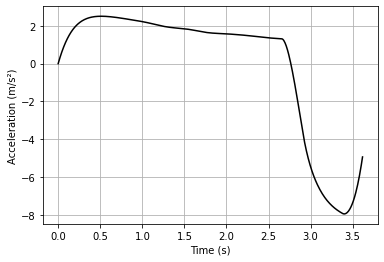

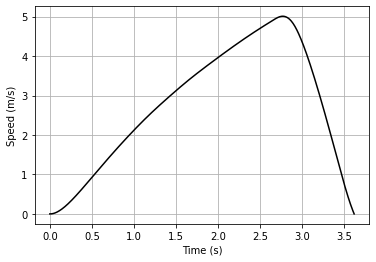

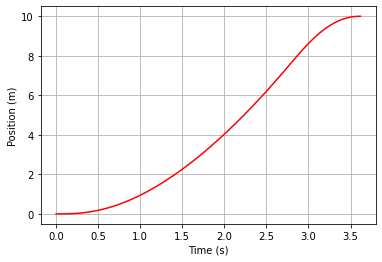

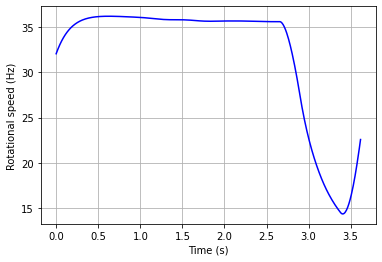

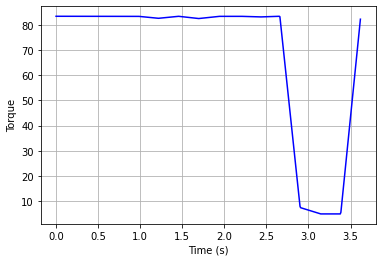

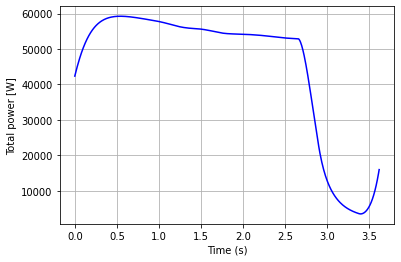

In [18]:
plot_trajectory(optim_problem.model.trajectory.trajectory.res)

In [19]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_outputs.xml')

The `optimizer_viewer` offers a convenient summary of the optimization result:

In [20]:
api.optimization_viewer(CONFIGURATION_FILE)

You can use the `VariableViewer` tool to see the optimization results for all variables of the system by loading the .xml output file:

In [21]:
api.variable_viewer(OUTPUT_FILE)

In [22]:
import openmdao.api as om
from models.multirotor import Multirotor
prob = om.Problem()
prob.model = Multirotor()

prob.setup(check=True)

RuntimeError: <model> <class Multirotor>: Output name 'data:system:MTOW' refers to multiple outputs: ['mtow.data:system:MTOW', 'system_constraints.mtow.data:system:MTOW'].